In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpt
import seaborn as sns
import re
#  设置对应字体文件的路径
myfont = mpt.font_manager.FontProperties(fname = r'msyhbd.ttc', size = 20) 
sns.set(font = myfont.get_name()) 

In [3]:
df_job = pd.read_json('job_全国_Python_2018_05_06.json')
df_job.head()

,city,company_full_names,company_name,create_time,positionId,positionName,salary
0,北京,人人行科技有限公司,人人行(借贷宝),2018-05-03,4485685,python开发工程师,15k-30k
1,上海,上海清鹤科技股份有限公司,清鹤科技,2018_05_06 11:28,4524762,Python开发工程师,10k-20k
2,北京,北京蚂蜂窝网络科技有限公司,马蜂窝,2018_05_06 01:27,4165288,高级Python工程师,15k-25k
3,北京,北京猎户星空科技有限公司,猎户星空,2018_05_07 16:49,4488877,Python工程师,15k-30k
4,北京,北京优虎商务服务有限公司,老虎证券,2018-05-04,4467387,Python开发工程师,20k-40k


In [4]:
df_job.shape

(1725, 7)

# 一、数据处理
* 去重
* create_time: 只保留年月日
* salary: 分割成最大薪水和最小薪水，针对“..k以上”的情况，将这个值同时作为最大和最小薪水
* company_full_names and company_name: 公司全称和简称有些不能一一对应，用遍历的方式匹配错误项并改正
* positionName: 将单词都统一成小写形式

## 1、去重

In [5]:
# 去重
df_job = df_job.drop_duplicates()   
#重排列索引
df_job.index = np.arange(len(df_job))
df_job.shape

(1697, 7)

## 2、清洗时间

In [6]:
#  清洗时间
#  只提取年月日
def CleanTime(df_job):
    time = []                          
    pat = re.compile('[_ -]')                           #  以空格、-、_  作为分割位 
    for i in range(len(df_job['create_time'])):
        da = pat.split(df_job['create_time'][i])
        t = da[0] + "-" + da[1] + "-" + da[2]          #  连接年月日  
        time.append(t)
    df_job.create_time = time
    return df_job


In [7]:
df_job = CleanTime(df_job)
df_job.head()

,city,company_full_names,company_name,create_time,positionId,positionName,salary
0,北京,人人行科技有限公司,人人行(借贷宝),2018-05-03,4485685,python开发工程师,15k-30k
1,上海,上海清鹤科技股份有限公司,清鹤科技,2018-05-06,4524762,Python开发工程师,10k-20k
2,北京,北京蚂蜂窝网络科技有限公司,马蜂窝,2018-05-06,4165288,高级Python工程师,15k-25k
3,北京,北京猎户星空科技有限公司,猎户星空,2018-05-07,4488877,Python工程师,15k-30k
4,北京,北京优虎商务服务有限公司,老虎证券,2018-05-04,4467387,Python开发工程师,20k-40k


## 3、清洗薪水

In [8]:
#  清洗薪水
#  提取数字，排除k、K
def CleanSalary(df_job):
    pat = re.compile(r'\d+')               
    smin = []
    smax = []
    for i in range(len(df_job['salary'])):
        da = pat.findall(df_job['salary'][i])
        smin.append(int(da[0]))
        smax.append(int(da[-1]))   #  对有异常的最大薪水进行处理，设为倒数第一个
    salary = np.mean(np.array([smin,smax]),axis = 0)  #  取平均值作为薪水
    df_job['min_salary'] = smin
    df_job['max_salary'] = smax
    df_job['avg_salary'] = salary.tolist()
    return df_job


In [9]:
df_job = CleanSalary(df_job)
df_job.head()

,city,company_full_names,company_name,create_time,positionId,positionName,salary,min_salary,max_salary,avg_salary
0,北京,人人行科技有限公司,人人行(借贷宝),2018-05-03,4485685,python开发工程师,15k-30k,15,30,22.5
1,上海,上海清鹤科技股份有限公司,清鹤科技,2018-05-06,4524762,Python开发工程师,10k-20k,10,20,15.0
2,北京,北京蚂蜂窝网络科技有限公司,马蜂窝,2018-05-06,4165288,高级Python工程师,15k-25k,15,25,20.0
3,北京,北京猎户星空科技有限公司,猎户星空,2018-05-07,4488877,Python工程师,15k-30k,15,30,22.5
4,北京,北京优虎商务服务有限公司,老虎证券,2018-05-04,4467387,Python开发工程师,20k-40k,20,40,30.0


## 4、清洗公司名单

In [10]:
#  公司全称与简称可能没有一一对应
def CleanCompany(df_job):
    compare = {'company_full_names':'company_name',
              'company_name':'company_full_names'
              }
    temp = []
    for comp in compare.keys():
        i = len(df_job[comp].drop_duplicates())
        print(comp,'个数：',i)
        temp.append(i)
    if len(set(temp)) == 1:
        print('匹配正确')
    else:
        print('匹配错误','\n\n')
        #  当出现匹配错误时，找出错误的行
        #  1、公司全称相同却有不同简称的行
        #  2、公司简称相同却有不同全称的行
        count = 1  #  错误计数
        for comp in compare:
            company_list = df_job[comp].drop_duplicates().tolist()  #  公司全称或简称的名单
            for company in company_list:
                df = df_job[df_job[comp] == company]
                if len(df[compare[comp]].drop_duplicates()) > 1:
                    print('第%d个匹配错误'%count,df[list(compare.keys())],'\n','-'*20)
                    count += 1
        print('匹配结束','\n','-'*20)
           

In [11]:
CleanCompany(df_job)

company_name 个数： 1086
company_full_names 个数： 1093
匹配错误 


第1个匹配错误      company_name company_full_names
17           美团点评       北京三快在线科技有限公司
491          美团点评         上海威烁热能有限公司
673          美团点评       北京三快在线科技有限公司
678          美团点评       北京三快在线科技有限公司
766          美团点评       北京三快在线科技有限公司
1049         美团点评       北京三快在线科技有限公司 
 --------------------
第2个匹配错误     company_name company_full_names
268         天广汇通       北京天广汇通科技有限公司
284         天广汇通       北京天广汇通科技有限公司
780         天广汇通  北京天广汇通科技有限公司成都分公司 
 --------------------
第3个匹配错误     company_name company_full_names
506         BTCC       上海晶赫网络科技有限公司
638         BTCC       上海掘东信息技术有限公司 
 --------------------
第4个匹配错误      company_name company_full_names
698          云数海量        小日子科技成都有限公司
985          云数海量     成都云数海量信息科技有限公司
1411         云数海量     成都云数海量信息科技有限公司 
 --------------------
第5个匹配错误      company_name company_full_names
841            币信     北京势在必行网络科技有限公司
1314           币信     北京必然如此网络技术有限公司 
 --------------------
第6个匹配错误      comp

* 公司全称相同却有不同简称的行
   * 第1个匹配错误：将第1321行的‘cloudin云英’修改成‘CloudIn’
   
   
   
* 公司简称相同却有不同全称的行
   * 第2个匹配错误：剔除掉‘上海威烁热能有限公司 ’这一行的记录 
   * 第3个匹配错误中三个记录同属一个总公司，将公司全称都改成‘北京天广汇通科技有限公司’
   * 第4-8出现的情况相同：在拉钩网上几个公司的简称确实都是一样的，但不是代表同一个，所以对其简称加个不同的记号

In [12]:
df_job.loc[1320,'company_name'] = 'CloudIn'
df_job = df_job.drop(491)
df_job.loc[780,'company_full_names'] = '北京天广汇通科技有限公司'
df_job.loc[506,'company_name'] = 'BTCC_2'
df_job.loc[698,'company_name'] = '云数海量_2'
df_job.loc[841,'company_name'] = '币信_2'
df_job.loc[887,'company_name'] = '金风科技_2'
df_job.loc[1028,'company_name'] = '同花顺_2'
df_job.loc[1109,'company_name'] = '同花顺_3'

#重新排一次列索引
df_job.index = np.arange(len(df_job.index))

In [13]:
CleanCompany(df_job)

company_name 个数： 1091
company_full_names 个数： 1091
匹配正确


## 5、清洗职位

In [14]:
#     字母大小写均有
#     将字母统一为小写
df_job.positionName = df_job.positionName.map(lambda x:x.lower())

# 二、分析
* 职位和时间
* 职位和公司
* 职位和城市

In [15]:
df_job = df_job[['city', 'company_full_names', 'company_name', 'create_time',
       'positionName', 'min_salary', 'max_salary',
       'avg_salary']]
df_job.head()

,city,company_full_names,company_name,create_time,positionName,min_salary,max_salary,avg_salary
0,北京,人人行科技有限公司,人人行(借贷宝),2018-05-03,python开发工程师,15,30,22.5
1,上海,上海清鹤科技股份有限公司,清鹤科技,2018-05-06,python开发工程师,10,20,15.0
2,北京,北京蚂蜂窝网络科技有限公司,马蜂窝,2018-05-06,高级python工程师,15,25,20.0
3,北京,北京猎户星空科技有限公司,猎户星空,2018-05-07,python工程师,15,30,22.5
4,北京,北京优虎商务服务有限公司,老虎证券,2018-05-04,python开发工程师,20,40,30.0


## 1、职位和时间

In [17]:
def TimePlot(df_job):
    df_time = df_job.create_time.value_counts()
    df_time = df_time.sort_index()
    sns.set(rc={"figure.figsize": (15,10)},font = myfont.get_name())
    sns.barplot(x = df_time.index, y = df_time.values, 
             color = sns.xkcd_rgb['pale red'])
    plt.title('发布的职位数量随时间变化的情况')
    plt.xticks(rotation = 45)

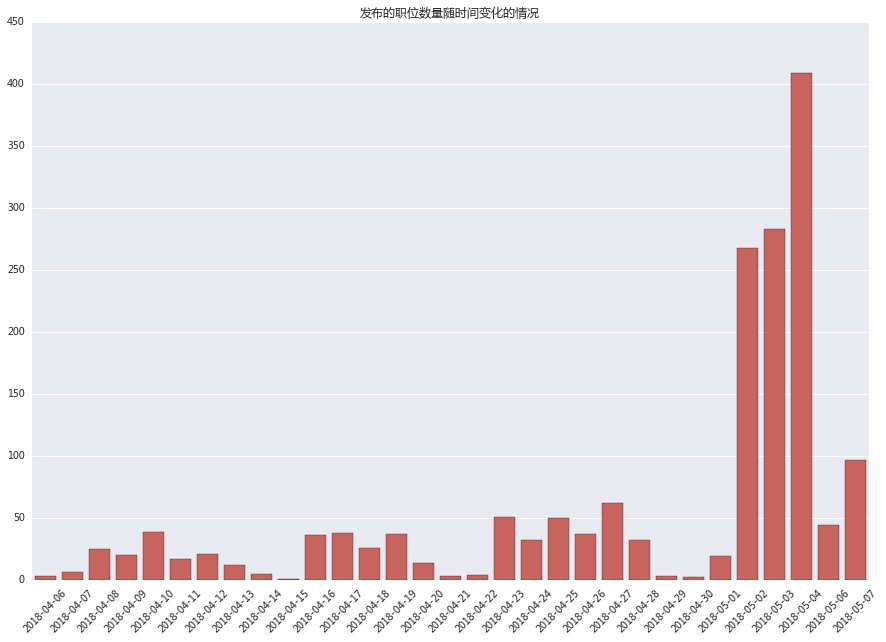

In [18]:
TimePlot(df_job)

* 职位发布量总体上是随时间变化而呈周期性变化，而且伴有上升的趋势
  * 这份数据是在5月初导出的，所以可能是因为先发布职位的公司先招到了人
  * 或是在拉勾网上发布职位有时间限制，先发布的职位先下架了

## 2、职位和公司

In [19]:
df_job.sort_index(by = 'max_salary', ascending = False)[:10]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,city,company_full_names,company_name,create_time,positionName,min_salary,max_salary,avg_salary
1359,北京,北京世纪好未来教育科技有限公司,好未来,2018-05-03,python后端架构师,35,70,52.5
640,上海,上海互趣网络科技有限公司,Amino,2018-05-04,java/python资深开发工程师,35,70,52.5
296,杭州,浙江九章资产管理有限公司,幻方量化,2018-05-04,python高级开发工程师,33,66,49.5
749,北京,中云网安科技（北京）有限公司,中云网安,2018-04-17,资深python研发工程师,30,60,45.0
1494,深圳,厦门笨鸟电子商务有限公司,笨鸟社交,2018-05-03,高级python爬虫工程师,40,60,50.0
547,北京,北京字节跳动科技有限公司,字节跳动,2018-05-03,高级python工程师,30,60,45.0
463,北京,北京汉迪移动互联网科技股份有限公司,iHandy,2018-05-03,高级python工程师,25,50,37.5
936,北京,北京犀牛瀚海科技有限责任公司,犀牛科技,2018-04-25,python,25,50,37.5
672,北京,北京三快在线科技有限公司,美团点评,2018-04-27,ai平台python研发工程师,25,50,37.5
1347,北京,北京九州云动科技有限公司,省钱快报,2018-05-04,服务端架构师(php&amp;python),30,50,40.0


* python相关职位最高薪资前10名的公司分别是
      1、 北京世纪好未来教育科技有限公司
      2、 上海互趣网络科技有限公司
      3、 浙江九章资产管理有限公司
      4、 中云网安科技（北京）有限公司
      5、 厦门笨鸟电子商务有限公司
      6、 北京字节跳动科技有限公司
      7、 北京汉迪移动互联网科技股份有限公司
      8、 北京犀牛瀚海科技有限责任公司
      9、 北京三快在线科技有限公司
      10、 北京九州云动科技有限公司
      其中有7个公司都在北京

## 3、职位和城市

In [20]:
#  画图
#  不同城市对职位的需求量以及薪资（以平均薪资为准）
def CityPlot(df_job,temp_1,temp_2):
    df_job['rate'] = 1/len(df_job)
    #  不同城市的需求量及平均薪资分布
    sns.set_style("ticks")
    sns.set(rc={"figure.figsize": (15,10)},font = myfont.get_name(),palette = 'Set2')
    
    ax1 = plt.subplot2grid((1,2),(0,0))
    sns.barplot(y = 'city',x = 'rate',data = df_job,estimator = sum,orient = 'h',color = 'salmon')
    plt.xlabel('需求量占比')
    plt.title('不同城市的需求量分布情况')
    
    df_job['rate'] = 1/len(df_job)
    city_list = df_job.city.drop_duplicates()
    count = temp_1
    for city in city_list:
        x = df_job[df_job.city == city].rate.sum()
        plt.text(x+0.015, count,str(round(x,4)),fontsize = 8,ha = 'center',va = 'bottom')
        count += temp_2

    ax2 = plt.subplot2grid((1,2),(0,1))
    sns.boxplot(y = 'city',x = 'avg_salary',data = df_job,orient = 'h',color = 'salmon')
    #   所有城市的平均薪资,  取两位小数
    avg_salary = df_job.avg_salary.mean()
    plt.plot([avg_salary,avg_salary],[0,200], 'go--', label='平均薪资 (%dk/月)'%avg_salary, linewidth=2,markersize=0)
    plt.legend(bbox_to_anchor=(1,0.1))
    plt.xlabel('平均薪资 k/月')
    plt.title('不同城市的薪资分布情况')
    
    

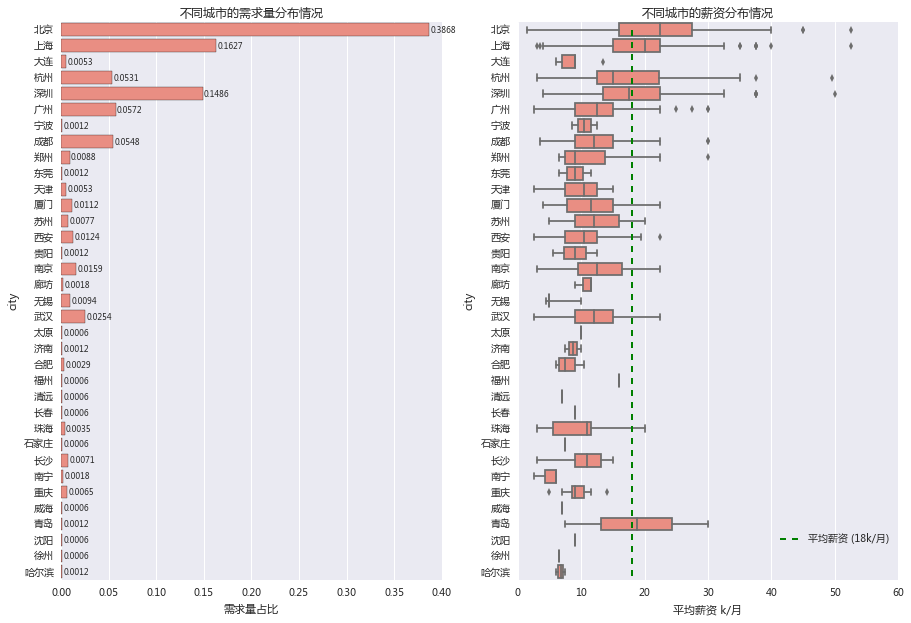

In [21]:
CityPlot(df_job,0.3,1)

* 北京、上海、杭州、深圳、广州、成都占据了近90%的需求量，是从事python相关职位人员的首选，其中北京、上海、青岛的平均薪资高于全国平均水平，北京和上海是高需求，高薪资的城市。

In [23]:
def SalaryDistPlot(df_job):
    sns.distplot(df_job.avg_salary.values)
    plt.xlabel('平均薪资 k/月')
    plt.title('平均薪资分布情况')

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


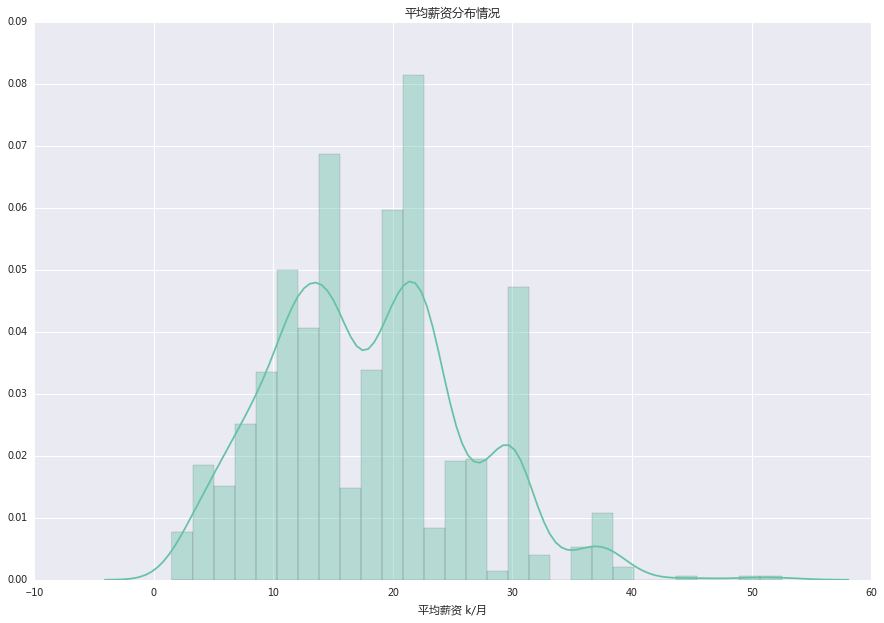

In [24]:
SalaryDistPlot(df_job)

* python相关岗位的从业人员平均月薪为18.03k，薪资的分布主要是集中在10-25k

下面对需求量占比前6的北京、上海、杭州、深圳、广州、成都这几个城市的职业分类进行分析

In [25]:
#  传入城市名单，筛选出对应城市
def SelectCity(df_job,city_list):
    cond = []
    for i ,ch in enumerate(df_job.city.values):
        if ch in city_list:
            cond.append(i)
    #  重排行索引
    d = df_job.loc[cond]
    d.index = np.arange(len(d))
    return d

city_list = ['北京','上海','杭州','深圳','广州','成都']
df_top_city = SelectCity(df_job,city_list)
df_top_city.head()

,city,company_full_names,company_name,create_time,positionName,min_salary,max_salary,avg_salary,rate
0,北京,人人行科技有限公司,人人行(借贷宝),2018-05-03,python开发工程师,15,30,22.5,0.00059
1,上海,上海清鹤科技股份有限公司,清鹤科技,2018-05-06,python开发工程师,10,20,15.0,0.00059
2,北京,北京蚂蜂窝网络科技有限公司,马蜂窝,2018-05-06,高级python工程师,15,25,20.0,0.00059
3,北京,北京猎户星空科技有限公司,猎户星空,2018-05-07,python工程师,15,30,22.5,0.00059
4,北京,北京优虎商务服务有限公司,老虎证券,2018-05-04,python开发工程师,20,40,30.0,0.00059


In [26]:
#position = ['总裁','经理','总监','主管','助理','专员','秘书','顾问']
#position = ['普通','高级','实习','资深','中级','经理','初级','架构','总监']

#  传入职位的关键词，职位加入分类标签
#  当出现一个职位名称中有多个关键词的情况时，以靠前的关键词为准
def MatchPosition(df_top_city,position):
    #  搜索职位关键词是否出现在职位名称上
    lis = []
    for i in range(len(df_top_city)):
        for pos in position:
            if pos in df_top_city.loc[i,'positionName']:
                lis.append(df_top_city.loc[i].values.tolist() + [pos])
                break
    #  在原来的df上再添一个维度：category 即职位的分类标签
    return pd.DataFrame(lis,columns = df_top_city.columns.tolist() + ['category'])

#### 实习、讲师、爬虫、后端、架构、运维、全栈、数据

In [27]:
position = ['实习','讲师','爬虫','后端','架构','运维','全栈','数据']
#  将职位分成几类
df_1 = MatchPosition(df_top_city,position)
df_1.head()

,city,company_full_names,company_name,create_time,positionName,min_salary,max_salary,avg_salary,rate,category
0,上海,宏居网络技术（上海）有限公司,Juwai,2018-05-04,python开发／后端软件工程师.,20,30,25.0,0.00059,后端
1,上海,上海极值信息技术有限公司,上海极值信息技术有限公司,2018-05-04,爬虫-高级工程师(python),15,20,17.5,0.00059,爬虫
2,杭州,杭州康策网络科技有限公司,康策网络,2018-05-02,python/爬虫开发,8,15,11.5,0.00059,爬虫
3,上海,实投（上海）互联网金融信息服务有限公司,实投互联网金融,2018-04-09,运维工程师/python开发,10,20,15.0,0.00059,运维
4,上海,上海厚本金融信息服务有限公司,厚本金融,2018-05-04,python/go 运维开发工程师,15,25,20.0,0.00059,运维


In [28]:
#  在图形上标注对应数值
#  ax：坐标轴句柄
#  city_list：筛选的城市名单
#  category_list：筛选的职位分类名单
#  temp_1：数值标注初始化
#  temp_2：数值标注步长
#  fontsize：标注的数值的字体大小
def TextPlot(ax,df,city_list,category_list,temp_1,temp_2,fontsize):
    df['rate'] = 1/len(df)
    cs = -temp_1
    for pos in category_list:
        count = 0
        for city in city_list:
            df_1 = df[df.city == city]
            y = df_1[df_1.category == pos].rate.sum()
            ax.text(count+cs,y,str(round(y,2)),fontsize = fontsize,ha = 'center',va = 'bottom')
            count += 1
        cs += temp_2

#  画图
#  不同城市及不同种类的职位的需求量和薪资（以平均薪资为准）情况
def SalaryPlot(df,temp_1,temp_2,fontsize):
    sns.set_style("ticks")
    sns.set(rc={"figure.figsize": (20,15)},font = myfont.get_name())
    #  薪资图
    plt.subplot2grid((2,1),(0,0))
    sns.boxplot(x = 'city',y = 'avg_salary',hue = 'category',
                data = df,palette=sns.color_palette('Set1',8))
    plt.ylabel('薪资水平')
    plt.title('不同城市及职位的薪资分布情况')
    #  需求量图
    df['rate'] = 1/len(df)
    plt.subplot2grid((2,1),(1,0))
    ax = sns.barplot(x = 'city',y = 'rate',hue = 'category',data = df,
              palette=sns.color_palette('Set1',8),ci = 0,estimator = sum)
    plt.ylabel('需求量占比')
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('不同城市及职位的需求量分布情况')
    #  标注数值
    city_list = df.city.drop_duplicates().tolist()
    category_list = df.category.drop_duplicates().tolist()
    TextPlot(ax,df,city_list,category_list,temp_1,temp_2,fontsize)

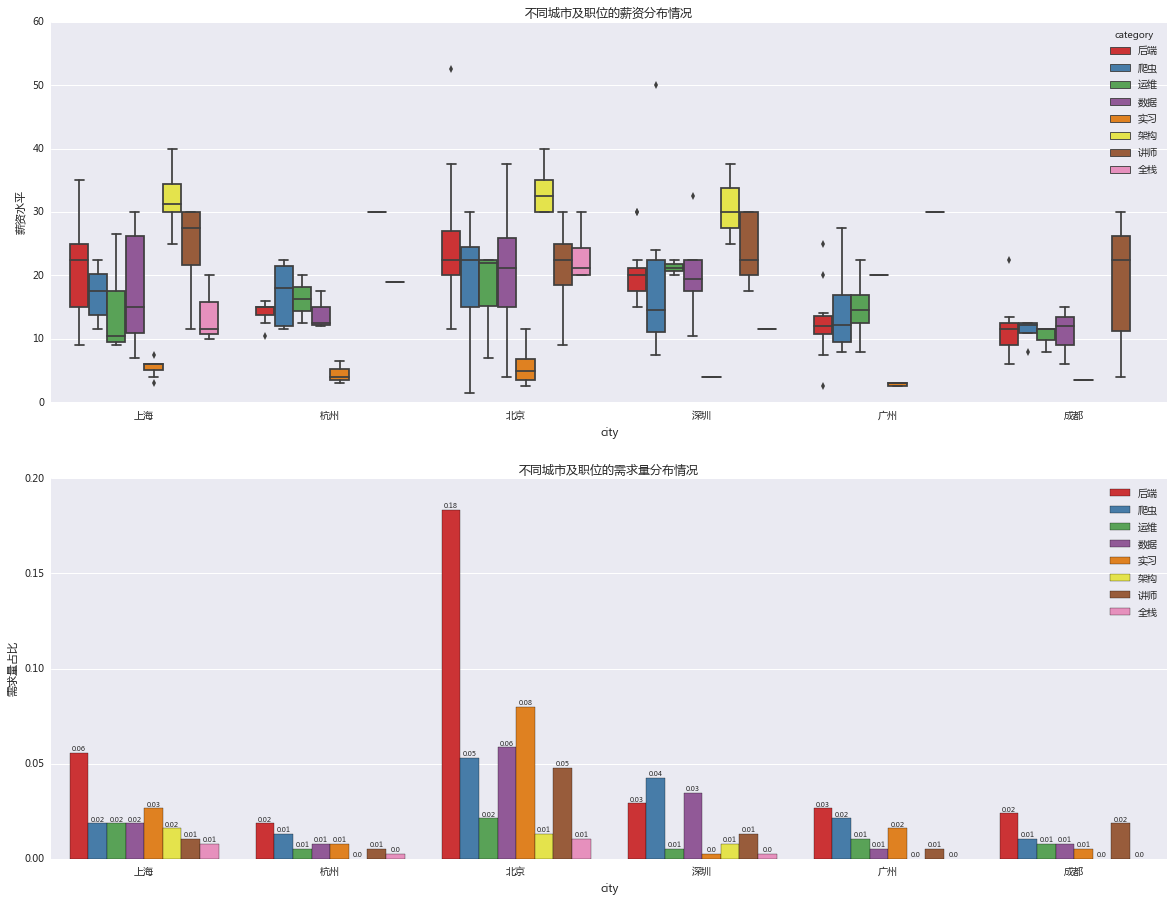

In [29]:
SalaryPlot(df_1,0.35,0.1,7)

* python架构工程师的薪资普遍较高，在30-40k之间，python实习生的薪资相对较低，在4-7k之间，北京和深圳有个别后端或爬虫工程师薪资在50k以上
* 后端工程师更受欢迎，北京对后端工程师的需求量占该城市总需求量的39.13%；实习生的薪资相对低，在上海、北京和广州等地的需求量仍然很大

#### 研发与开发

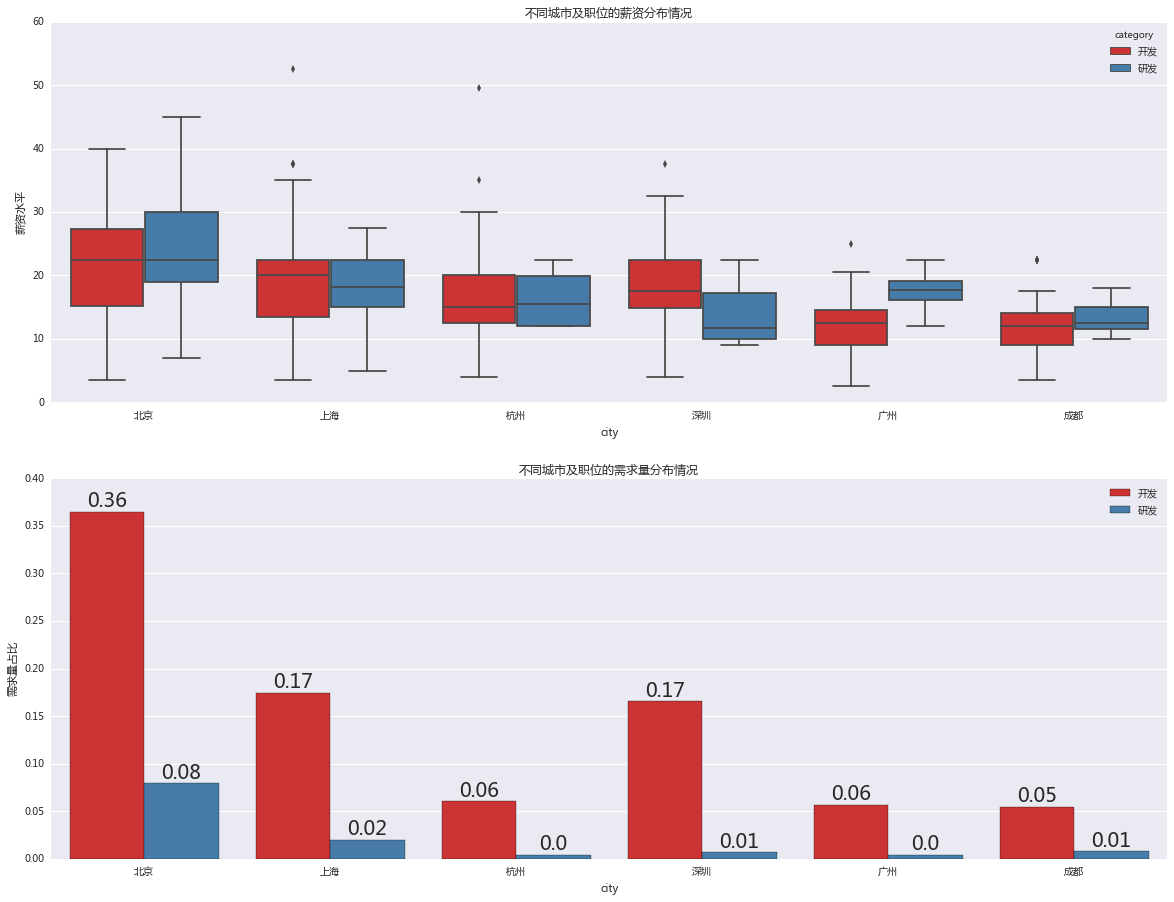

In [30]:
df_2 = MatchPosition(df_top_city,['研发','开发'])
SalaryPlot(df_2,0.2,0.4,20)


* 北京的开发工程师的需求量明显多于其他各大城市，占36.57%，研发工程师在各城市的需求量都明显少于开发工程师，在广州，研发工程师的薪资水平总体上都大于开发工程师，所以对于研发工程师来说，去广州工作是个不错的选择

#### 初级、中级、高级

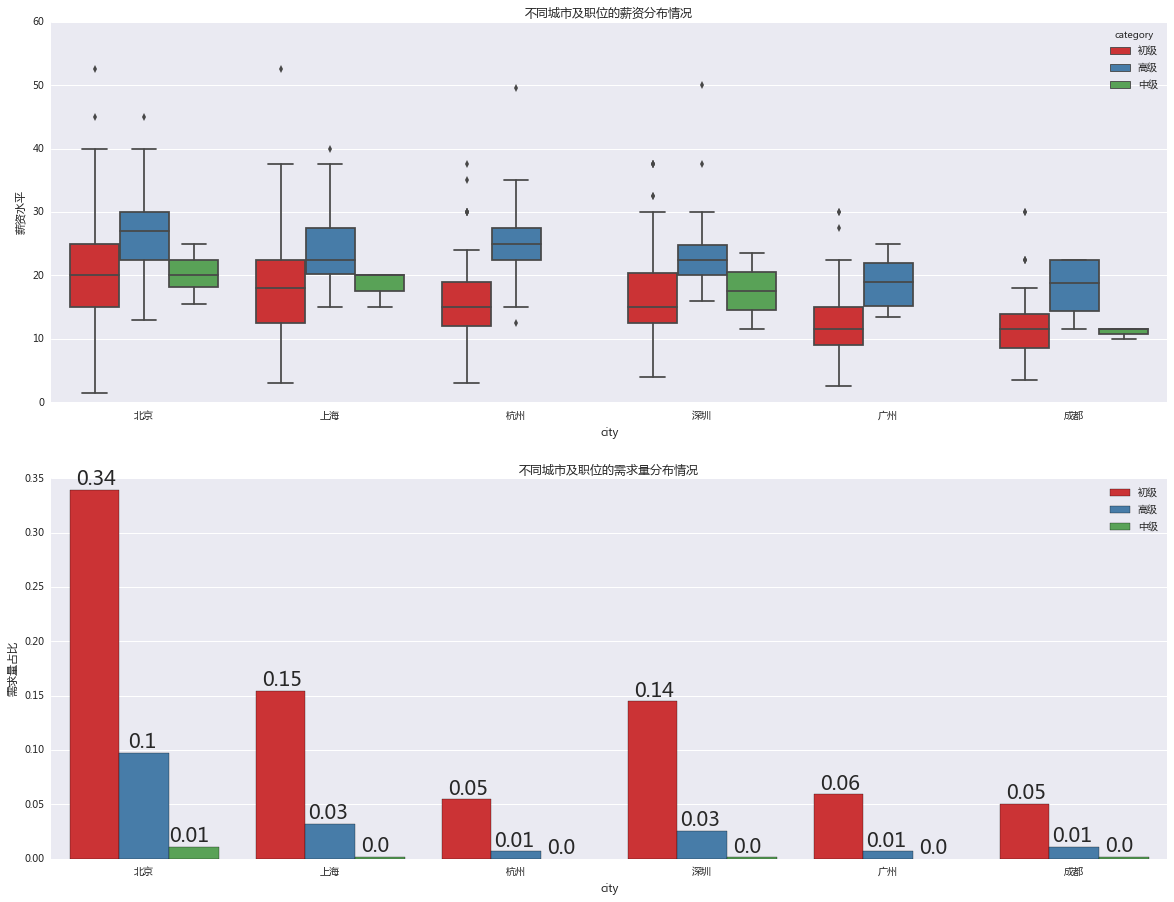

In [31]:
#  默认除高级和中级外其余都为初级
df_3 = MatchPosition(df_top_city,['高级','中级',''])
#  将空字符换成初级的职位
place = {'':'初级'}
df_3 = df_3.replace(place)

SalaryPlot(df_3,0.26,0.25,20)


* 75%的高级工程师的薪资都高于初级和中级工程师
* 初级工程师占据了市场80%的需求量

# 总结

     1、从地域来看，北京、上海、杭州、深圳、广州、成都应该是python相关从业人员的首选城市，占据了市场上近90%的需求量，其中，北京和上海是高薪资、高需求量的城市。
     2、从python职位的种类来看，架构工程师的薪资更高，而后端工程师则更受欢迎，所以对于研发工程师来说，去广州工作是个不错的选择。
     3、从python职位的等级来看，初级工程师占据了大部分市场，高级工程师的首选城市是北京